# Logistic regression

Here we shall implement the logistic regression model to our dataset.

In [1]:
# This is the code used to preprocess our dataset. 
# Each step is explained in detail in the 'Data Pre-processing' notebook.

import numpy as np
import pandas as pd

df = pd.read_csv('news.csv')
df['news'] = df['title'] + ' ' + df['text']
convert_to_binary = {'REAL':1,'FAKE':0}
df['label'] = df['label'].map(convert_to_binary)
df = df.drop([df.columns[0],df.columns[1],df.columns[2]],axis=1)
df = df.reindex(columns=['news','label'])

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

stop_words = stopwords.words('english')
stop_words.extend(['the','it','in'])
WNL = WordNetLemmatizer()

for index, row in df.iterrows():
    filtered_article = ''
    article = row['news']
    article = re.sub(r'[^\w\s]', '', article)
    words = [word.lower() for word in nltk.word_tokenize(article)]
    words = [word for word in words if not word in stop_words]
    words_lemmatized = []
    for word in words:
        if word == 'us':
            words_lemmatized.append(word)
        else:
            words_lemmatized.append(WNL.lemmatize(word))
    filtered_article = " ".join([word for word in words_lemmatized])
    df.loc[index, 'news'] = filtered_article
    
df.head()

,news,label
0,smell hillary fear daniel greenfield shillman ...,0
1,watch exact moment paul ryan committed politic...,0
2,kerry go paris gesture sympathy us secretary s...,1
3,bernie supporter twitter erupt anger dnc tried...,0
4,battle new york primary matter primary day new...,1


In [2]:
# Vectorization

df_input = df['news']
df_output = df['label']

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tf_idf_matrix = vectorizer.fit_transform(df_input)
tf_idf_matrix

<6335x80967 sparse matrix of type '<class 'numpy.float64'>'
	with 1762247 stored elements in Compressed Sparse Row format>

Now we have our input vectors, the rows of the matrix `tf_idf_matrix`, and our output labels, `df_output`.

In order to perform logistic regression, we first need to split the data into test and train data.

In [3]:
# We are performing a 75:25 split.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(tf_idf_matrix, df_output, random_state=42)

Now we can input the training data into a logistic regression model.

In [4]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')

logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
logreg.predict(x_test[0:10])

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

## Measuring model performance

We now have a logistic regression model fit to our training dataset. We are going to use accuracy as our metric to measure the model's performance. To do this we are going to see how the model performs on the test data. The accuracy is calculated as a percentage of the number of correct predictions in the test dataset.

In [6]:
accuracy = logreg.score(x_test, y_test)
accuracy

0.9172979797979798

So our accuracy is 91.7%. Not bad!

Let's see if changing the ratio of test to train data has any impact on our accuracy.

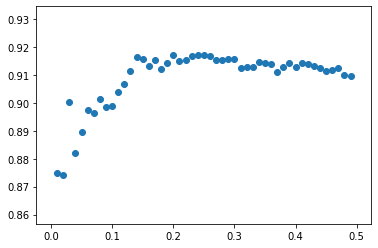

In [15]:
test_sizes = np.arange(0.01,0.5,0.01)
accuracys = []
for i in test_sizes:
    x_train, x_test, y_train, y_test = train_test_split(tf_idf_matrix, df_output, test_size=i, random_state=23)
    logreg.fit(x_train, y_train)
    accuracy = logreg.score(x_test, y_test)
    accuracys.append(accuracy)
    
import matplotlib.pyplot as plt
plt.scatter(test_sizes, accuracys)

In [16]:
test_sizes[np.argmax(accuracys)]

0.25

So this model gives the greatest accuracy when our train to test ratio is 75:25.

## Confusion Matrix

A good way of visualising the performance of our classifier is by using a confusion matrix. This is a matrix where the actual class is compared with the predicted class, so we can see where our model is going wrong most often.

In [9]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test,logreg.predict(x_test))

In [10]:
confusion_matrix

array([[1465,   96],
       [ 220, 1324]])

This means that of the $1576$ fake news articles in the test dataset, $1505$ were predicted correctly as fake by the model and $71$ were incorrectly predicted to be real. Of the $1529$ real news articles in the test dataset, $211$ were incorrectly predicted as fake and $1318$ were correctly predicted as real.

In [34]:
print('Success rate of model on fake news articles: ' + str(confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])))
print('Success rate of model on real news articles: ' + str(confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1])))

Success rate of model on fake news articles: 0.9385009609224856
Success rate of model on real news articles: 0.8575129533678757


So our model is more accurate when classifying fake news compared to real news.

## Validation set

Our logistic regression model has several different hyperparameters which we can finetune in order to perhaps increase the accuracy of our model. However, if we use the test dataset whilst finetuning these hyperparameters then the test data may become biased as our model will have already seen it. So we leave the test data unseen, only to be used once the model is complete to give a true representation of the model's accuracy. Instead, we split the data into a third part, called the validation set, which we can use to finetune the hyperparameters. We shall use a 60:20:20 split.

In [12]:
# 80% train and 20% test.
x_train3, x_test3, y_train3, y_test3 = train_test_split(tf_idf_matrix, df_output, test_size=0.2, random_state=42)

# Split train 75:25 as 0.8*0.25=0.2
# So now have 60% train, 20% validation and 20% test.
x_train3, x_val3, y_train3, y_val3 = train_test_split(x_train3, y_train3, test_size=0.25, random_state=42)

The logistic regression model has several different hyperparameters which may affect the accuracy. Different solvers `solver` can affect convergence, regularisation `penalty` can sometimes be helpful and the `C` parameter controls the penality strength, which can also be affective. Now let's try tweaking some of these hyperparameters to see, using the validation dataset, whether we can improve the accuracy of our model.

In [13]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(x_train3, y_train3)
print('Accuracy: ' + str(logreg.score(x_val3,y_val3)) + ' Solver: lbfgs')
logreg = LogisticRegression(solver='liblinear')
logreg.fit(x_train3, y_train3)
print('Accuracy: ' + str(logreg.score(x_val3,y_val3)) + ' Solver: liblinear')
logreg = LogisticRegression(solver='newton-cg')
logreg.fit(x_train3, y_train3)
print('Accuracy: ' + str(logreg.score(x_val3,y_val3)) + ' Solver: newton-cg')
logreg = LogisticRegression(solver='sag')
logreg.fit(x_train3, y_train3)
print('Accuracy: ' + str(logreg.score(x_val3,y_val3)) + ' Solver: sag')
logreg = LogisticRegression(solver='saga')
logreg.fit(x_train3, y_train3)
print('Accuracy: ' + str(logreg.score(x_val3,y_val3)) + ' Solver: saga')

Accuracy: 0.9100236779794791 Solver: lbfgs
Accuracy: 0.9108129439621152 Solver: liblinear
Accuracy: 0.9100236779794791 Solver: newton-cg
Accuracy: 0.9100236779794791 Solver: sag
Accuracy: 0.9108129439621152 Solver: saga


So we can see that the liblinear and saga solvers have a slightly greater accuracy, but there's really not much difference.

To test all different combinations of `solver`, `penalty` and `C`, we can use a gridsearch technique.

The function `GridSearchCV` has a built in method for splitting the data into training and validation data. In fact, its default is to use a method called 5-fold cross validation.

In [17]:
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression()
solvers = ['lbfgs','liblinear','newton-cg','sag','saga']
penalties = ['l1', 'l2', 'elasticnet', 'none']
C_values = [100,10,1,0.1,0.01]
grid = dict(solver=solvers, penalty=penalties, C=C_values)
grid_search = GridSearchCV(logreg, grid, n_jobs=-1, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(x_train, y_train)

# We may get some warnings as not all combinations work, e.g. not all solvers support all regularisation terms.

/Users/maxkirwan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/maxkirwan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/maxkirwan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [18]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
    
# A score of 0 means that it is not possible for the model to use this combination of hyperparameters.

0.0 (0.0) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.9058823529411765 (0.009204749791039843) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.0 (0.0) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.0 (0.0) with: {'C': 100, 'penalty': 'l1', 'solver': 'sag'}
0.9204334365325078 (0.0045069464271201625) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.9213622291021671 (0.0038777631277955417) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9213622291021671 (0.0038777631277955417) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.9213622291021671 (0.0038777631277955417) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.9235294117647059 (0.003425601338135435) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.9250773993808049 (0.0023307596902595795) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.0 (0.0) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.0 (0.0) with: {'C': 100, 'penalty': 'elasticnet', 'solver'

In [19]:
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))

Best: 0.926625386996904 using {'C': 10, 'penalty': 'none', 'solver': 'sag'}


Therefore we can conclude that the above combination of hyperparameters is optimal if we want to maximise the accuracy of our logistic regression classifier.

In [26]:
logreg = LogisticRegression(solver='sag',penalty='none')
logreg.fit(x_train, y_train)
logreg.score(x_test,y_test)

0.9368760064412238

## Testing our model on unseen data

Now that we have a working model, we would like to use it to classify unseen news articles.
However there is one major problem: the way that our model is built is by using the Tf-idf vectoriser, which creates a vector based on the frequency of terms in the entire corpus. So the only way to add articles to our model will be to alter these vectors. This means that we cannot just input new articles into our original model and get a classification. Instead, each time we would like to input a new unknown article, we will have to rebuild the Tf-idf matrix. Luckily this isn't too tricky and actually could be a good thing - it means that our model is always improving with each new article added.

In [20]:
# Creating a text pre-processor function.

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

stop_words = stopwords.words('english')
stop_words.extend(['the','it','in'])
WNL = WordNetLemmatizer()
    

def article_preprocessor (article):
    filtered_article = ''
    article = re.sub(r'[^\w\s]', '', article)
    words = [word.lower() for word in nltk.word_tokenize(article)]
    words = [word for word in words if not word in stop_words]
    words_lemmatized = []
    for word in words:
        if word == 'us':
            words_lemmatized.append(word)
        else:
            words_lemmatized.append(WNL.lemmatize(word))
    filtered_article = " ".join([word for word in words_lemmatized])
    return filtered_article

In [21]:
def logreg_classifier (list_of_articles):
    
    # Pre-process the articles
    articles_pp = [article_preprocessor(article) for article in list_of_articles]
    
    # Append new articles to original list of articles (df_input)
    new_input = df_input.append(pd.Series(articles_pp))
    
    # Vectorisation of new_input
    tf_idf_matrix = vectorizer.fit_transform(new_input)
    
    # Split matrix into original dataset and new data
    orig_data_matrix = tf_idf_matrix[:len(df_input)]
    new_data_matrix = tf_idf_matrix[len(df_input):]
    
    # Now perform logistic regression on original dataset
    x_train, x_test, y_train, y_test = train_test_split(orig_data_matrix, df_output, random_state=42)
    logreg = LogisticRegression(solver='lbfgs')
    logreg.fit(x_train, y_train)
    accuracy = logreg.score(x_test,y_test)
    print('Logistic regression model accuracy: ' + str(accuracy))
    # The model can now classify the new data
    predictions = logreg.predict(new_data_matrix)
    
    return predictions

Now that we have built a function to detect whether new articles are fake or not, let's put it to the test.

In [22]:
# The top news story on the BBC
bbc_news_article = '''The furlough scheme will be extended until the end of September by the chancellor in the Budget later.
Rishi Sunak said the scheme - which pays 80% of employees' wages for the hours they cannot work in the pandemic - would help millions through "the challenging months ahead".
Some 600,000 more self-employed people will also be eligible for government help as access to grants is widened.
But Labour said the support schemes should have been extended "months ago".
Mr Sunak will outline a three-point plan to support people through the coming months, rebuild the economy and "fix" the public finances in the wake of the pandemic when he delivers his statement to the Commons at about 12:30 GMT.
But he has warned of tough economic times ahead and there are reports that he plans to raise some taxes.'''

# Here's a fake news article from the New York Mag
fake_article = '''Twelve days out from judgment day in an election in which he continues to trail badly, President Trump continues to hammer home an issue that will surely resonate with that small slice of still-undecided voters: his supposedly unfair treatment at the hands of CBS’s Lesley Stahl. After two days of promising to release unedited footage of an as-yet-unaired 60 Minutes interview, during which he walked out prematurely because he was upset with Stahl’s line of questioning, the president finally followed through on Thursday. Throughout the interview, Stahl presses Trump on issues from health care (the president says he hopes the Supreme Court strikes down Obamacare, a politically toxic position) to his derogatory comments about Anthony Fauci (Trump claims he was misinterpreted) to his false claims that the Obama campaign spied on him. The tone is of an adversarial back-and-forth, well within normal journalistic bounds. Nevertheless, Trump continuously claims that Joe Biden hasn’t been given similar treatment by CBS and cuts the proceedings short.'''

In [23]:
articles = [bbc_news_article,fake_article]
logreg_classifier(articles)

Logistic regression model accuracy: 0.9172979797979798


array([1, 0])

Perfect! Our classifier has correctly predicted that the BBC news article is real `1` and that the NYmag article is fake `0`.